In [8]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from scipy import stats
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina'

import utils.plot_data as plot
import models.transforms as transforms
import algorithms.teaching_algs as algs
import evals.teaching_evals as evals

def get_ci(samples, confidence=0.95):  return stats.sem(samples) * stats.t.ppf((1 + confidence) / 2., len(samples)-1)
def get_random_score(dist_m, m, X, y_train, y_test, n_trials=1000):
    random_scores = np.array([evals.get_knn_score_lpips(dist_m, algs.random(X, m), y_train, y_test) for _ in range(n_trials)])
    random_ci = get_ci(random_scores)
    random_score = random_scores.mean()
    return random_score, random_ci

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
dataset = "bird"
transform = transforms.shrink((64,64))
# transform = transforms.bird_transform()

In [156]:
train = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/train", transform=transform)
test = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/test", transform=transform)
x_train = np.array([x[0].numpy() for x in train])
x_test = np.array([x[0].numpy() for x in test])
y_train = np.array([x[1] for x in train])
y_test = np.array([x[1] for x in test])

lpips_path = f"data/dist/lpips/{dataset}"
lpips_alex = pickle.load(open(f"{lpips_path}/lpips.alex.test.pkl","rb"))
lpips_vgg = pickle.load(open(f"{lpips_path}/lpips.vgg.test.pkl","rb"))
lpips_squeeze = pickle.load(open(f"{lpips_path}/lpips.squeeze.test.pkl","rb"))

In [168]:
x_pixel = np.array([x.flatten() for x in x_train])
x_50 = pickle.load(open(f"/net/scratch/tianh/ai-driven-tutorial/data/embeds/resn/{dataset}/{dataset}_train_emb50.pkl","rb"))
x_512 = pickle.load(open(f"/net/scratch/tianh/ai-driven-tutorial/data/embeds/resn/{dataset}/{dataset}_train_emb512.pkl","rb"))

In [169]:
m_range = np.arange(3,21)
lw = 4

In [170]:
def get_full_random(m_range, lpips, X, y_train, y_test):
    full_score = evals.get_knn_score_lpips(lpips, np.arange(len(y_train)), y_train, y_test, k=1)
    random_scores = []
    random_cis = []
    for m in m_range:
        random_score, random_ci = get_random_score(lpips, m, X, y_train, y_test)
        random_scores.append(random_score)
        random_cis.append(random_ci)
    random_scores = np.array(random_scores)
    random_cis = np.array(random_cis)
    return full_score, random_scores
    
def get_pdash_scores(m_range, lpips, X, y_train, y_test):
    return np.array([evals.get_knn_score_lpips(lpips, algs.protodash(X, m), y_train, y_test, k=1) for m in m_range])

def get_k_medoids_scores(m_range, lpips, X, y_train, y_test):
    return np.array([evals.get_knn_score_lpips(lpips, algs.k_medoids(X, m), y_train, y_test, k=1) for m in m_range])

In [171]:
def get_df(X):
    agent_df = {}
    for i, (lpips, title) in enumerate([(lpips_alex, "lpips_alex"), (lpips_vgg, "lpips_vgg"), (lpips_squeeze,"lpips_squeeze")]):
        full_score, random_scores = get_full_random(m_range, lpips, X, y_train, y_test)
        k_medoids_scores = get_k_medoids_scores(m_range, lpips, X, y_train, y_test)
        pdash_scores = get_pdash_scores(m_range, lpips, X, y_train, y_test)

        data = {"full_score": [full_score]*len(m_range), 
                "random_score": random_scores,
                "k_medoids_scores": k_medoids_scores,
                "pdash_scores": pdash_scores}
        df = pd.DataFrame(data)
        df = df.set_index(m_range)
        agent_df[title] = df
        return df
        
    return agent_df

In [172]:
titles = ["image pixel", "resn_d=512", "resn_d=50"]
df_pixel = get_df(x_pixel)
df_512 = get_df(x_512)
df_50 = get_df(x_50)

Text(0.5, 1, 'lpips_knn: bm')

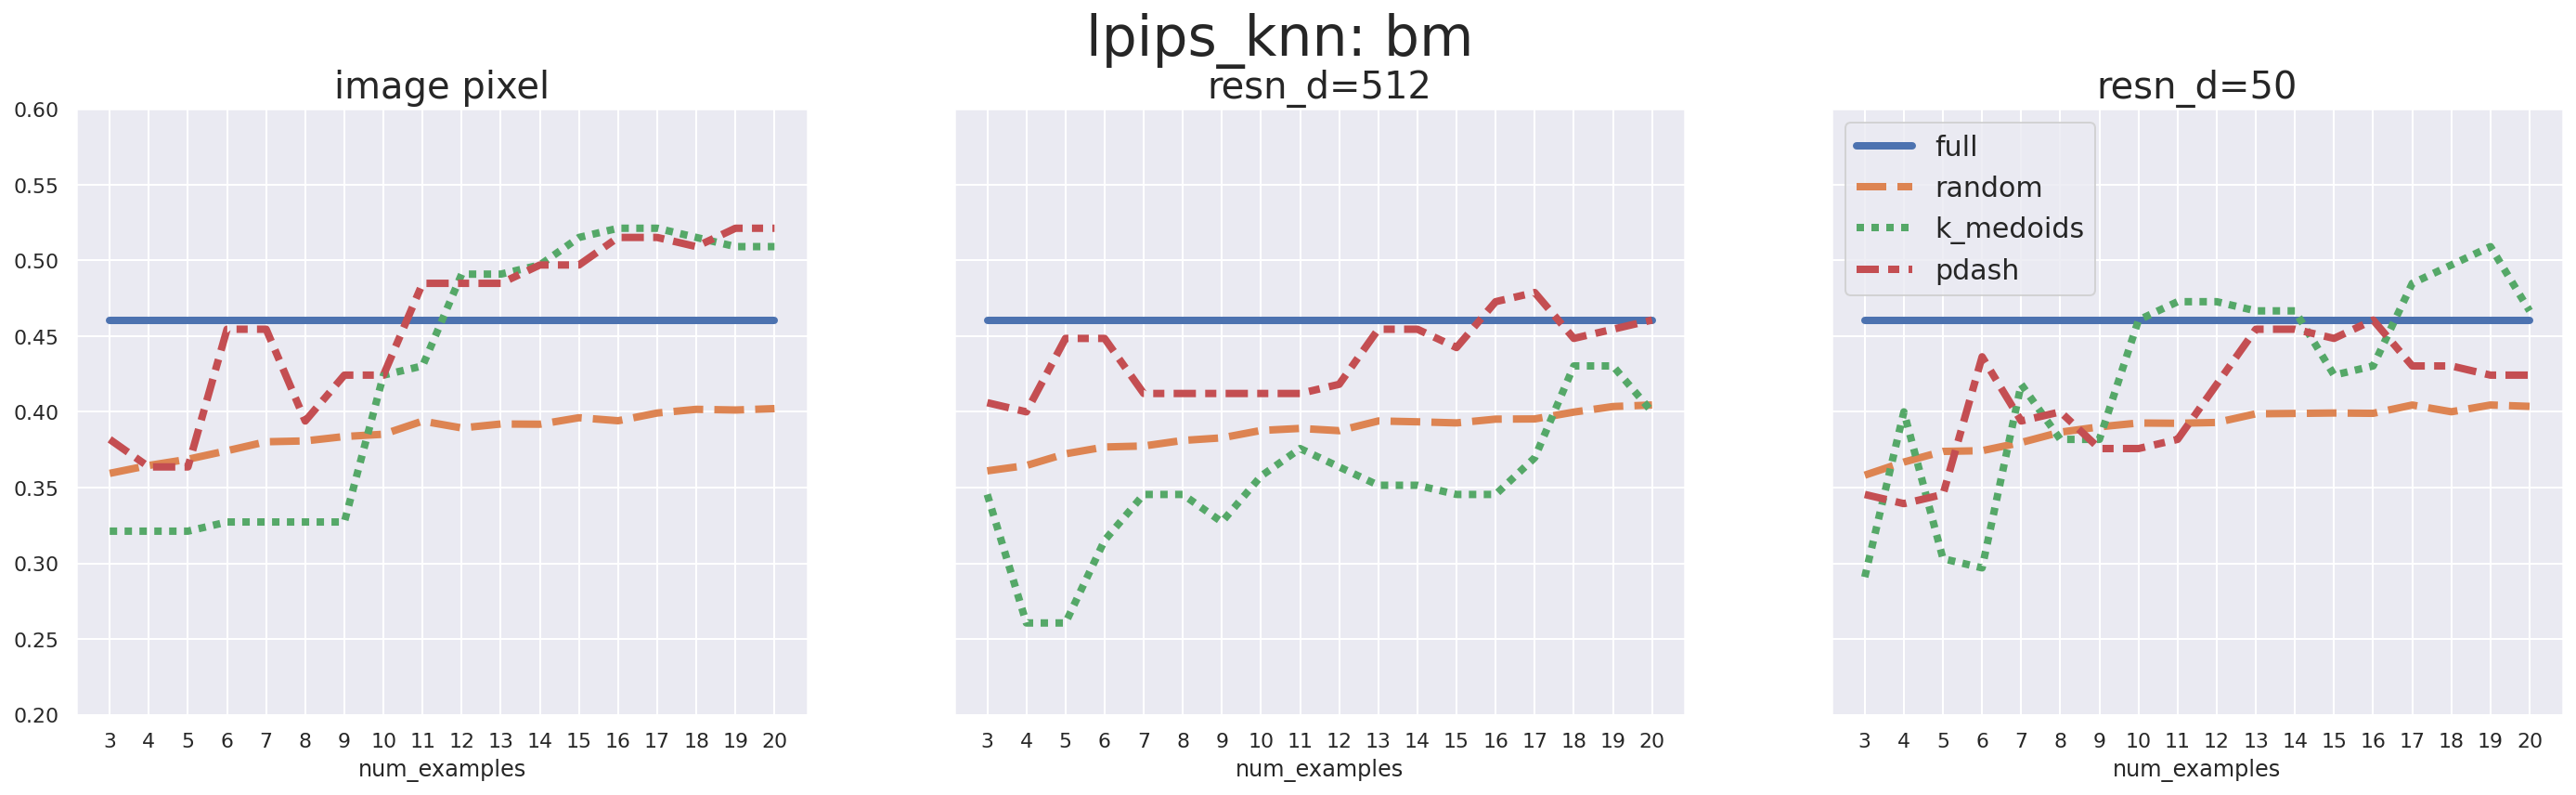

In [173]:
sns.set_theme()
plt.rc('legend', fontsize=15)    # legend fontsize

fig, ax = plt.subplots(1,3 , figsize=(8*3, 6), sharey=True, sharex=True)
for i, (df, title) in enumerate(zip([df_pixel, df_512, df_50], titles)):
    sns.lineplot(data=df, lw=4, ax=ax[i], legend=None)
    ax[i].set_xlabel("num_examples")
    ax[i].set_title(title, fontsize=20)
plt.xticks(m_range)
plt.ylim([0.2, 0.6])
ax[2].legend(["full", "random", "k_medoids", "pdash"])
fig.suptitle("lpips_knn: bm", y=1)